# KAN Symbol Error Rate (SER) Analysis & Laboratory

This notebook performs a comprehensive analysis of Kolmogorov-Arnold Networks (KAN) for **4CSK** and **8CSK** modulation. 

**Key Features:**
- **Robust Data Logging**: All experiment results are saved to `.csv` files for later analysis.
- **Detailed Metrics**: Confusion Matrices and Classification Reports.
- **Scientific Plotting**: Figures formatted for IEEE publication standards (saved as PNG and EPS).

## Datasets
- `data_4csk.csv`
- `data_8csk.csv`

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import os
from tqdm import tqdm
import itertools

# Import KAN implementation
try:
    from torch_relu_kan import ReLUKAN
except ImportError:
    print("Error: torch_relu_kan.py not found. Please ensure it stands in the same directory.")

# Setup Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set seeds for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

# Create Output Directory
OUTPUT_DIR = "results"
os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f"Results will be saved to: {OUTPUT_DIR}/")

# Define FNN Model for comparison
class FNN(nn.Module):
    """Simple Feedforward Neural Network with ReLU activations."""
    def __init__(self, input_dim, hidden_dims, output_dim):
        super(FNN, self).__init__()
        layers = []
        prev_dim = input_dim
        for h_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, h_dim))
            layers.append(nn.ReLU())
            prev_dim = h_dim
        layers.append(nn.Linear(prev_dim, output_dim))
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        # x shape: (batch, features, 1) -> squeeze to (batch, features)
        if x.dim() == 3:
            x = x.squeeze(-1)
        return self.network(x).unsqueeze(-1)  # Return (batch, output, 1)

print("FNN model class defined.")

Using device: cuda
Results will be saved to: results/
FNN model class defined.


## 1. IEEE Plotting Style Configuration

In [2]:
# Configure Matplotlib for IEEE Scientific Style
# Ensure Times New Roman or similar serif font is used
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times New Roman'],
    'font.size': 18,
    'axes.labelsize': 18,
    'axes.titlesize': 16,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'legend.fontsize': 18,
    'figure.titlesize': 18,
    'figure.dpi': 300,
    'text.usetex': False,
    'axes.grid': True,
    'grid.alpha': 0.3,
    'grid.linestyle': '--',
    'lines.linewidth': 2,
    'axes.prop_cycle': plt.cycler(color=['#0072BD', '#D95319', '#EDB120', '#7E2F8E', '#77AC30', '#4DBEEE', '#A2142F']) # MATLAB-like high contrast colors
})
print("IEEE Plotting Style Applied.")

IEEE Plotting Style Applied.


## 2. Utilities: Data Loading, Training, & Evaluation

In [3]:
def load_data(filepath, feature_cols, target_col='Symbol', train_size=64, test_size=None, normalize=True, return_numpy=False):
    """Loads, splits, and optionally scales data. Default train_size is 64 samples."""
    try:
        df = pd.read_csv(filepath)
    except FileNotFoundError:
        print(f"File {filepath} not found!")
        return None, None, None, None, None

    X = df[feature_cols].values
    y = df[target_col].values
    
    if test_size is not None:
        # First split train vs rest
        X_train, X_rest, y_train, y_rest = train_test_split(
            X, y, train_size=train_size, random_state=SEED, stratify=y
        )
        # Then split test from rest if test_size is specified and adequate
        if len(X_rest) > test_size:
             # We want exactly test_size for testing.
             X_test, _, y_test, _ = train_test_split(X_rest, y_rest, train_size=test_size, random_state=SEED, stratify=y_rest)
        else:
             if len(X_rest) < test_size:
                 print(f"Warning: Not enough samples for requested test_size {test_size}. Using all {len(X_rest)} remaining.")
             X_test, y_test = X_rest, y_rest
    else:
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, train_size=train_size, random_state=SEED, stratify=y
        )
    
    # Scale
    if normalize:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
    
    if return_numpy:
        return X_train, X_test, y_train, y_test, len(np.unique(y))

    # Convert to tensors
    X_train = torch.FloatTensor(X_train).unsqueeze(-1).to(device)
    y_train = torch.LongTensor(y_train).to(device)
    X_test = torch.FloatTensor(X_test).unsqueeze(-1).to(device)
    y_test = torch.LongTensor(y_test).to(device)
    
    return X_train, X_test, y_train, y_test, len(np.unique(y))

In [4]:
def train_model(model, X_train, y_train, X_test, y_test, epochs=200, lr=0.01, weight_decay=1e-4, verbose=False):
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.5)

    history = {'train_loss': [], 'test_ser': [], 'test_acc': []}
    best_ser = 1.0
    best_model_state = None

    iterator = range(epochs)
    if verbose:
        iterator = tqdm(iterator, desc="Training")

    for epoch in iterator:
        model.train()
        optimizer.zero_grad()
        output = model(X_train).squeeze(-1)
        loss = criterion(output, y_train)
        loss.backward()
        optimizer.step()
        
        history['train_loss'].append(loss.item())

        # Evaluation
        model.eval()
        with torch.no_grad():
            test_out = model(X_test).squeeze(-1)
            test_loss = criterion(test_out, y_test)
            _, preds = torch.max(test_out, 1)
            accuracy = (preds == y_test).float().mean().item()
            ser = 1.0 - accuracy
            
            history['test_ser'].append(ser)
            history['test_acc'].append(accuracy)
            
            if ser < best_ser:
                best_ser = ser
                best_model_state = copy.deepcopy(model.state_dict())
        
        scheduler.step(test_loss)
        
        if verbose and (epoch % 50 == 0):
            iterator.set_postfix(loss=loss.item(), ser=ser)

    return best_ser, history, best_model_state

In [5]:
def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix", filename=None):
    cm = confusion_matrix(y_true, y_pred)
    # Creating a nicely formatted IEEE style figure
    plt.figure(figsize=(5, 4)) # Compact figure for column width
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, linewidths=0.5, linecolor='black')
    plt.xlabel('Predicted Symbol')
    plt.ylabel('True Symbol')
    # plt.title(title) # Title removed per user request
    plt.grid(False) # Remove grid for CM
    plt.tight_layout()
    
    if filename:
        # Save as PNG
        path_png = os.path.join(OUTPUT_DIR, filename)
        plt.savefig(path_png, dpi=300, bbox_inches='tight')
        
        # Save as EPS
        path_eps = path_png.replace('.png', '.pdf')
        plt.savefig(path_eps, format='pdf', dpi=300, bbox_inches='tight')
        
        print(f"Saved CM plot to {path_png} and {path_eps}")
    plt.show()

## 3. Experiment 1: Feature Selection

--- Experiment 1: Combined Feature & Hyperparameter Search (Mean Selection) ---
Searching data_4csk.csv...
Best for data_4csk.csv: $T$ | Mean SER 0.2135 (+/- 0.0195)
Searching data_8csk.csv...
Best for data_8csk.csv: $T$ | Mean SER 0.1094 (+/- 0.0000)


<Figure size 3000x1800 with 0 Axes>

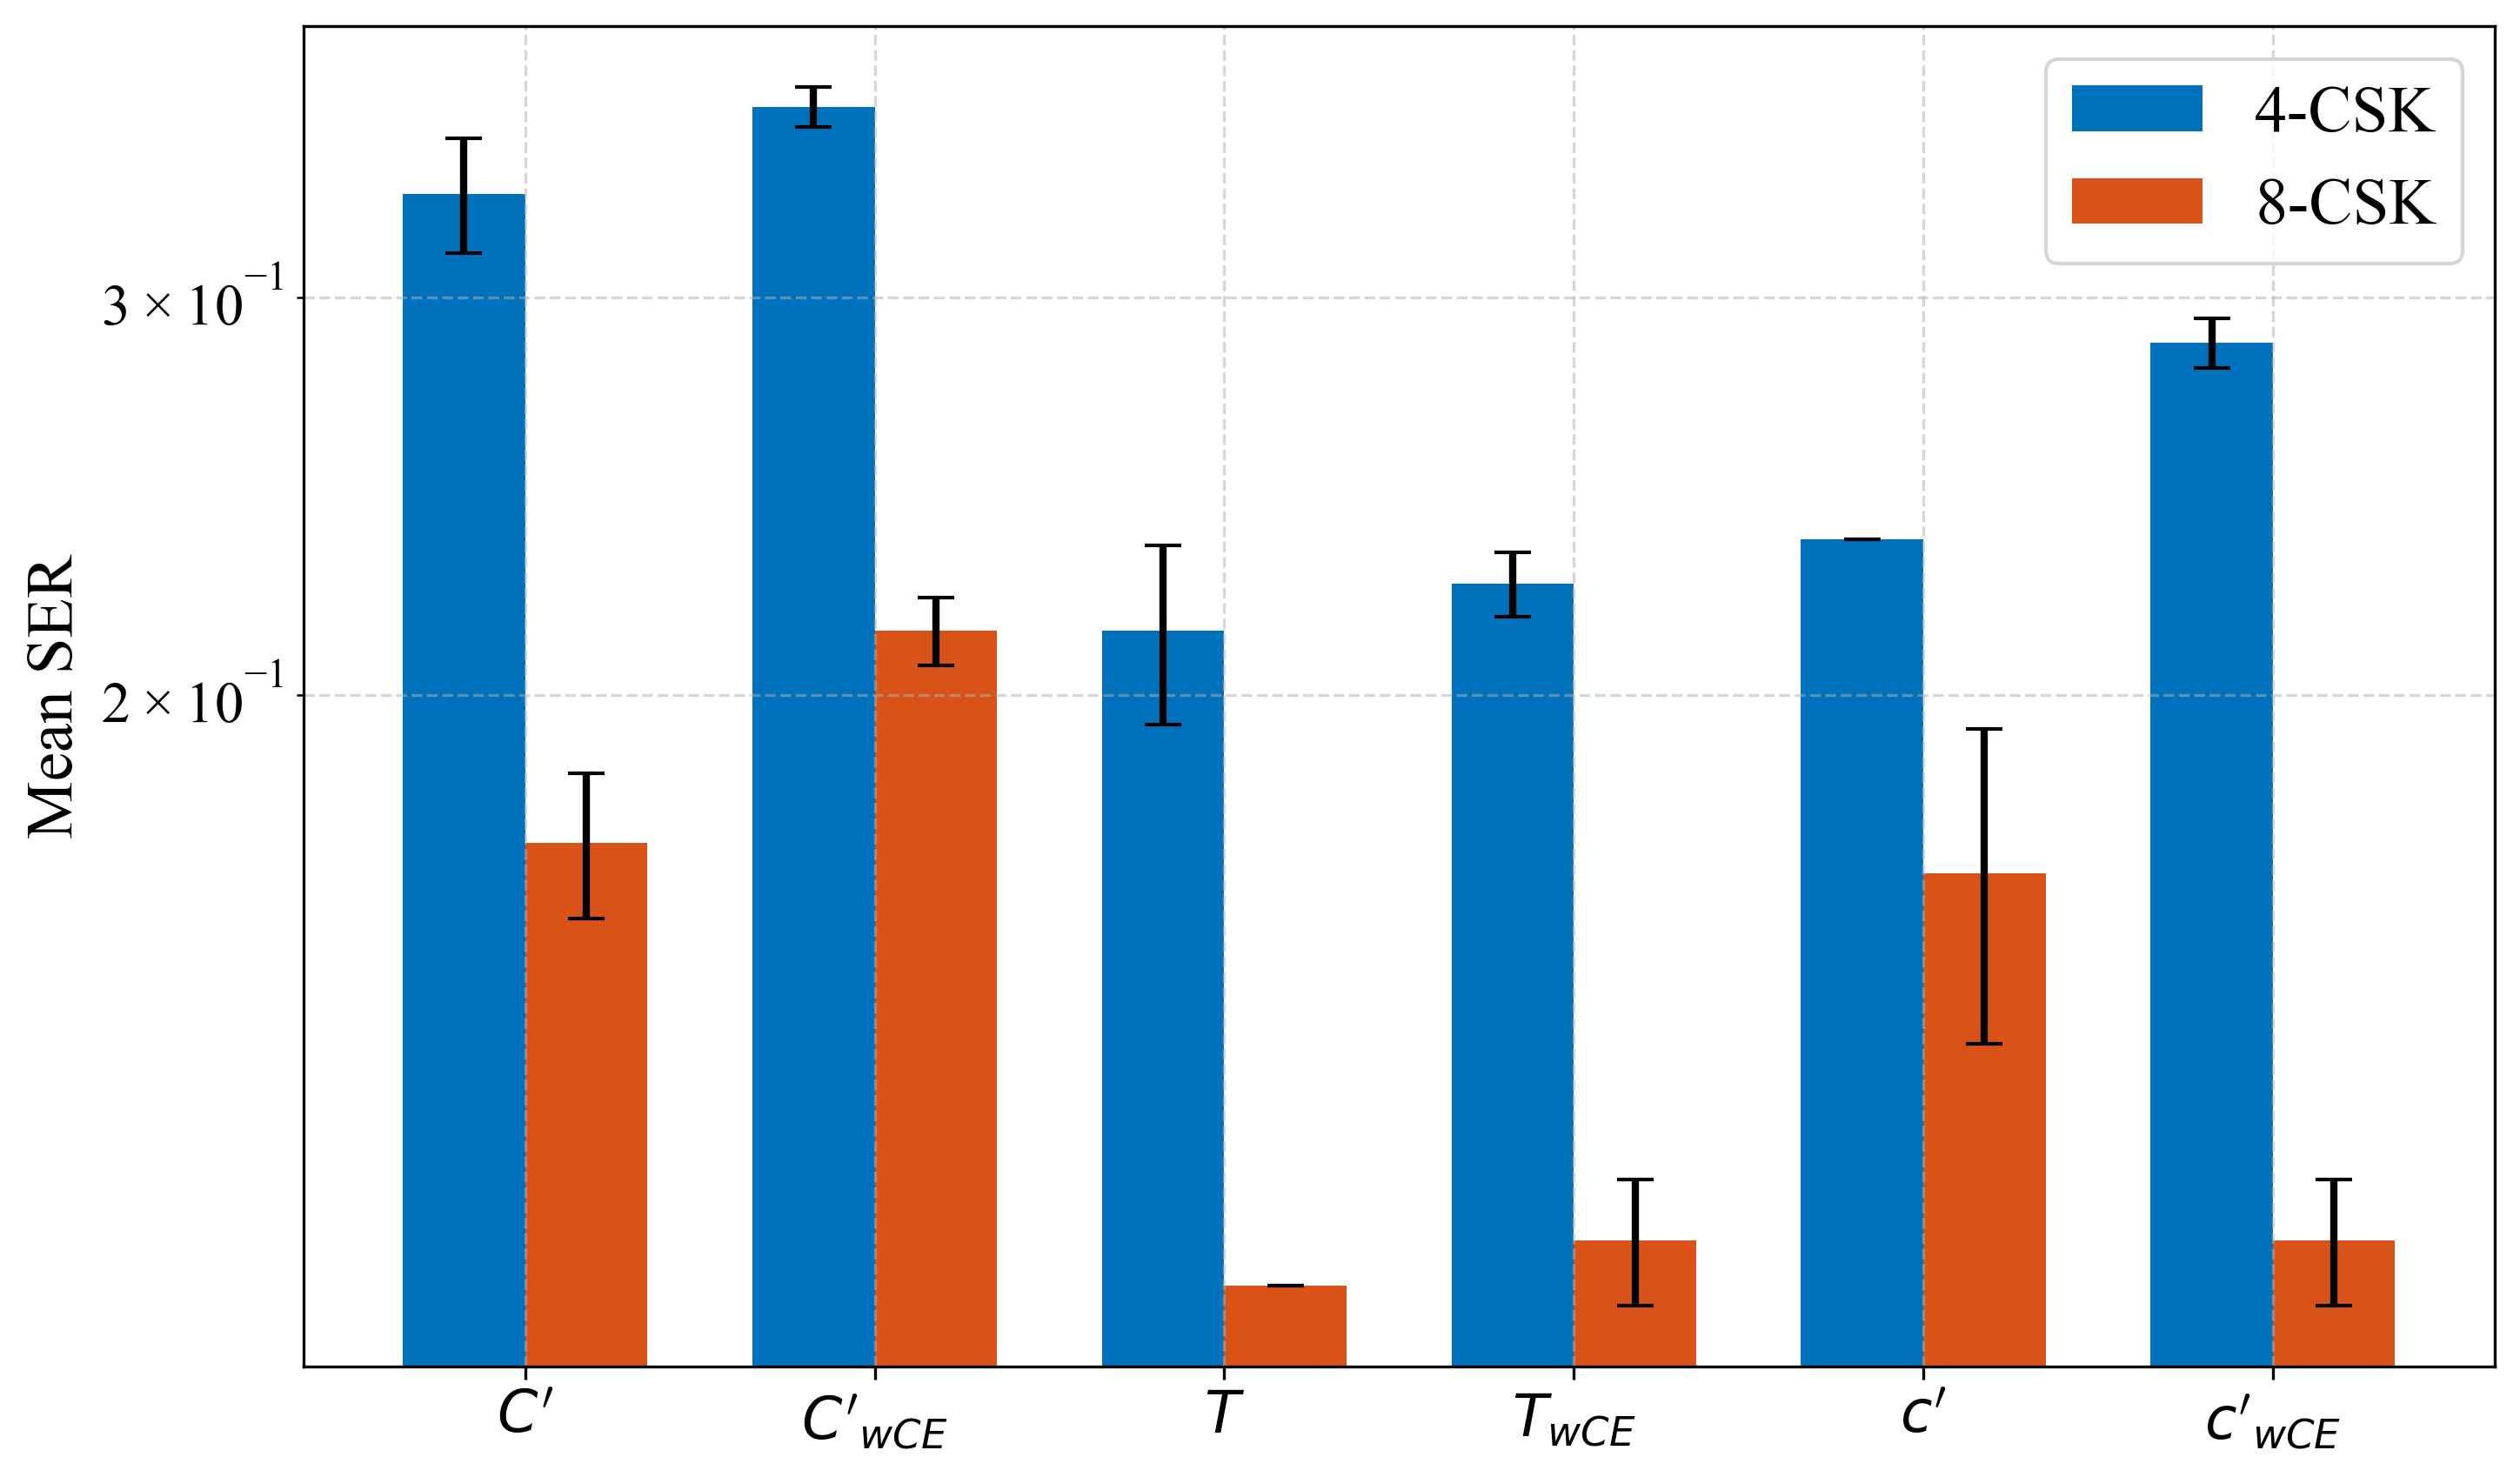

In [6]:
# Global dictionaries to store best configurations
best_features_global = {}
best_params_global = {}

feature_candidates = {
    r'$T_{wCE}$': ['Vr', 'Vg', 'Vb'],
    r'$T$': ['R', 'G', 'B'],
    r"$C'$": ['X', 'Y', 'Z'],
    r"$c'$": ['x', 'y'],
    r"$C'_{wCE}$": ['X_ne', 'Y_ne', 'Z_ne'],
    r"$c'_{wCE}$": ['x_ne', 'y_ne']
}   

# Hyperparameter Grid
param_grid = {
    'grid': [3],
    'k': [4],
    'lr': [ 1e-3],
    'weight_decay': [1e-3],
    'hidden_layers': [[10], [25], [100], [10,10], [10,10,10]]
}

keys, values = zip(*param_grid.items())
permutations = [dict(zip(keys, v)) for v in itertools.product(*values)]

# Storage for aggregation
results_comb = {'Dataset': [], 'Feature_Set': [], 'Params': [], 'Layers': [], 'Mean_SER': [], 'Std_SER': []}

print("--- Experiment 1: Combined Feature & Hyperparameter Search (Mean Selection) ---")
N_REPEATS = 3  # Repeats for statistical validity
SEARCH_EPOCHS =  50 # Reduced epochs for faster search

for filename in ['data_4csk.csv', 'data_8csk.csv']:
    print(f"Searching {filename}...")
    best_mean_ser_file = 1.0
    best_config_file = {}

    norm = True

    for feat_name, cols in feature_candidates.items():
        X_train, X_test, y_train, y_test, num_classes = load_data(
            filename, cols, train_size=64, test_size=64, normalize=norm
        )

        for params in permutations:
            sers = []
            layers = [len(cols)] + params['hidden_layers'] + [num_classes]
            
            # Repeat training to get mean/std
            for _ in range(N_REPEATS):
                model = ReLUKAN(layers, grid=params['grid'], k=params['k']).to(device)
                best_ser_run, _, _ = train_model(model, X_train, y_train, X_test, y_test, 
                                             epochs=SEARCH_EPOCHS, lr=params['lr'], weight_decay=params['weight_decay'], verbose=False)
                sers.append(best_ser_run)
            
            mean_ser = np.mean(sers)
            std_ser = np.std(sers)

            results_comb['Dataset'].append(filename)
            results_comb['Feature_Set'].append(feat_name)
            results_comb['Params'].append(str(params))
            results_comb['Layers'].append(str(params['hidden_layers']))
            results_comb['Mean_SER'].append(mean_ser)
            results_comb['Std_SER'].append(std_ser)

            if mean_ser < best_mean_ser_file:
                best_mean_ser_file = mean_ser
                best_config_file = {'cols': cols, 'name': feat_name, 'params': params, 'norm': norm, 'mean': mean_ser, 'std': std_ser}

    best_features_global[filename] = {'cols': best_config_file['cols'], 'norm': best_config_file['norm']}
    best_params_global[filename] = best_config_file['params']

    print(f"Best for {filename}: {best_config_file['name']} | Mean SER {best_config_file['mean']:.4f} (+/- {best_config_file['std']:.4f})")

df_res = pd.DataFrame(results_comb)
df_res['Dataset'] = df_res['Dataset'].replace({'data_4csk.csv': '4-CSK', 'data_8csk.csv': '8-CSK'})
df_res.to_csv(os.path.join(OUTPUT_DIR, 'results_combined_search.csv'), index=False)
# Plotting: Bar plot of the BEST configuration for each Feature Set
# Get best metrics per (Dataset, Feature_Set)
best_indices = df_res.groupby(['Dataset', 'Feature_Set'])['Mean_SER'].idxmin()
df_best_per_feat = df_res.loc[best_indices].copy()

plt.figure(figsize=(10, 6))
sns.barplot(x='Feature_Set', y='Mean_SER', hue='Dataset', data=df_best_per_feat, capsize=.1)
plt.clf() # Clear previous
datasets = df_best_per_feat['Dataset'].unique()
features = df_best_per_feat['Feature_Set'].unique()
x = np.arange(len(features))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
for i, ds in enumerate(datasets):
    subset = df_best_per_feat[df_best_per_feat['Dataset'] == ds]
    # Ensure order matches 'features'
    subset = subset.set_index('Feature_Set').reindex(features).reset_index()
    
    ax.bar(x + i*width, subset['Mean_SER'], width, label=ds, yerr=subset['Std_SER'], capsize=5)

ax.set_ylabel('Mean SER')
ax.set_xticks(x + width / 2 if len(datasets) > 1 else x)
ax.set_xticklabels(features)
ax.legend()
ax.set_yscale('log')
ax.grid(True, linestyle='--', which='both', alpha=0.5)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'plot_combined_search.png'), dpi=300)
plt.savefig(os.path.join(OUTPUT_DIR, 'plot_combined_search.pdf'), format='pdf', dpi=300)


## 4. Experiment 2: Hyperparameter Tuning (Grid Search)

In [7]:
print("--- Experiment 2: Redundant (Merged into Exp 1) ---")
# This experiment is skipped as Feature & Hyperparameter search are now combined in Experiment 1.


--- Experiment 2: Redundant (Merged into Exp 1) ---


## 5. Experiment 3: Sample Efficiency

## 5a. KAN vs FNN Detailed Comparison



--- Experiment 3a: KAN vs FNN Detailed Comparison (Sample Efficiency) ---
Training on [8, 16, 32...1024] samples, testing on 1024 samples
Dataset: data_4csk.csv
Processing train size: 8
Processing train size: 128
Processing train size: 256
Processing train size: 384
Processing train size: 512
Processing train size: 640
Processing train size: 768
Processing train size: 896
Processing train size: 1024
Dataset: data_8csk.csv
Processing train size: 8
Processing train size: 128
Processing train size: 256
Processing train size: 384
Processing train size: 512
Processing train size: 640
Processing train size: 768
Processing train size: 896
Processing train size: 1024
Sample Efficiency Experiment Complete.
Generating Sample Efficiency Plots...
Saved plot to results\plot_sample_efficiency_4CSK.pdf


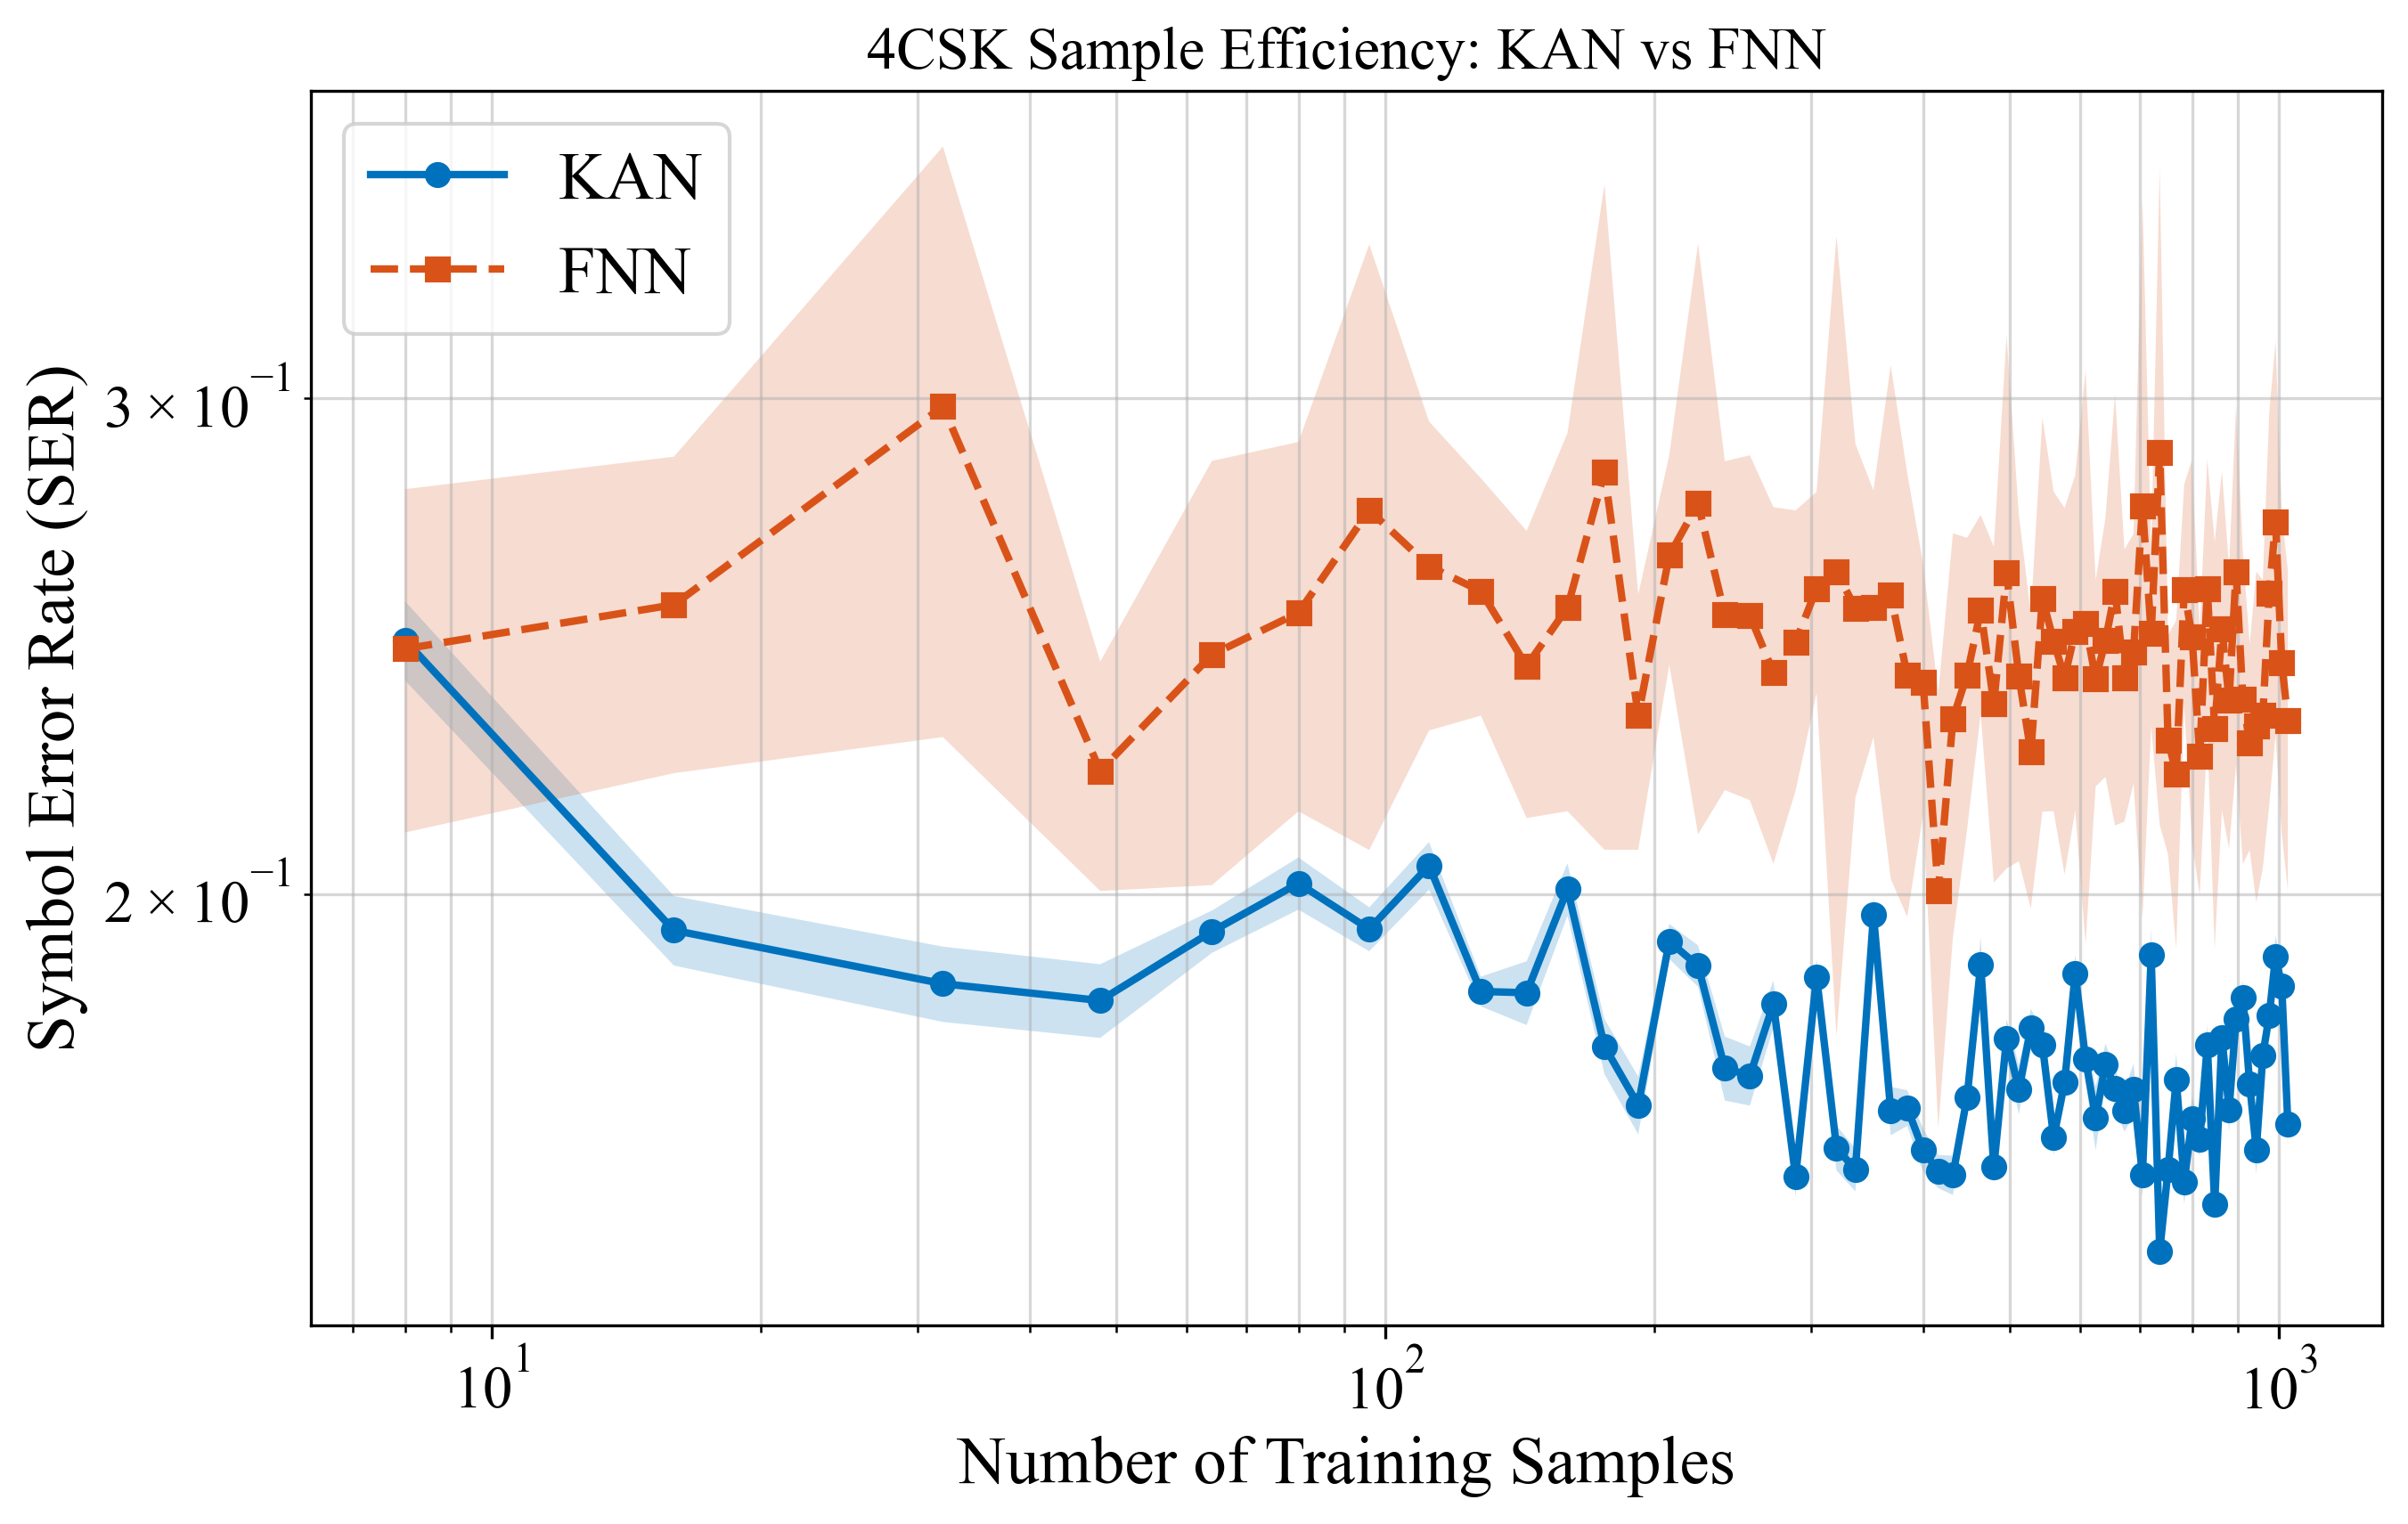

Saved plot to results\plot_sample_efficiency_8CSK.pdf


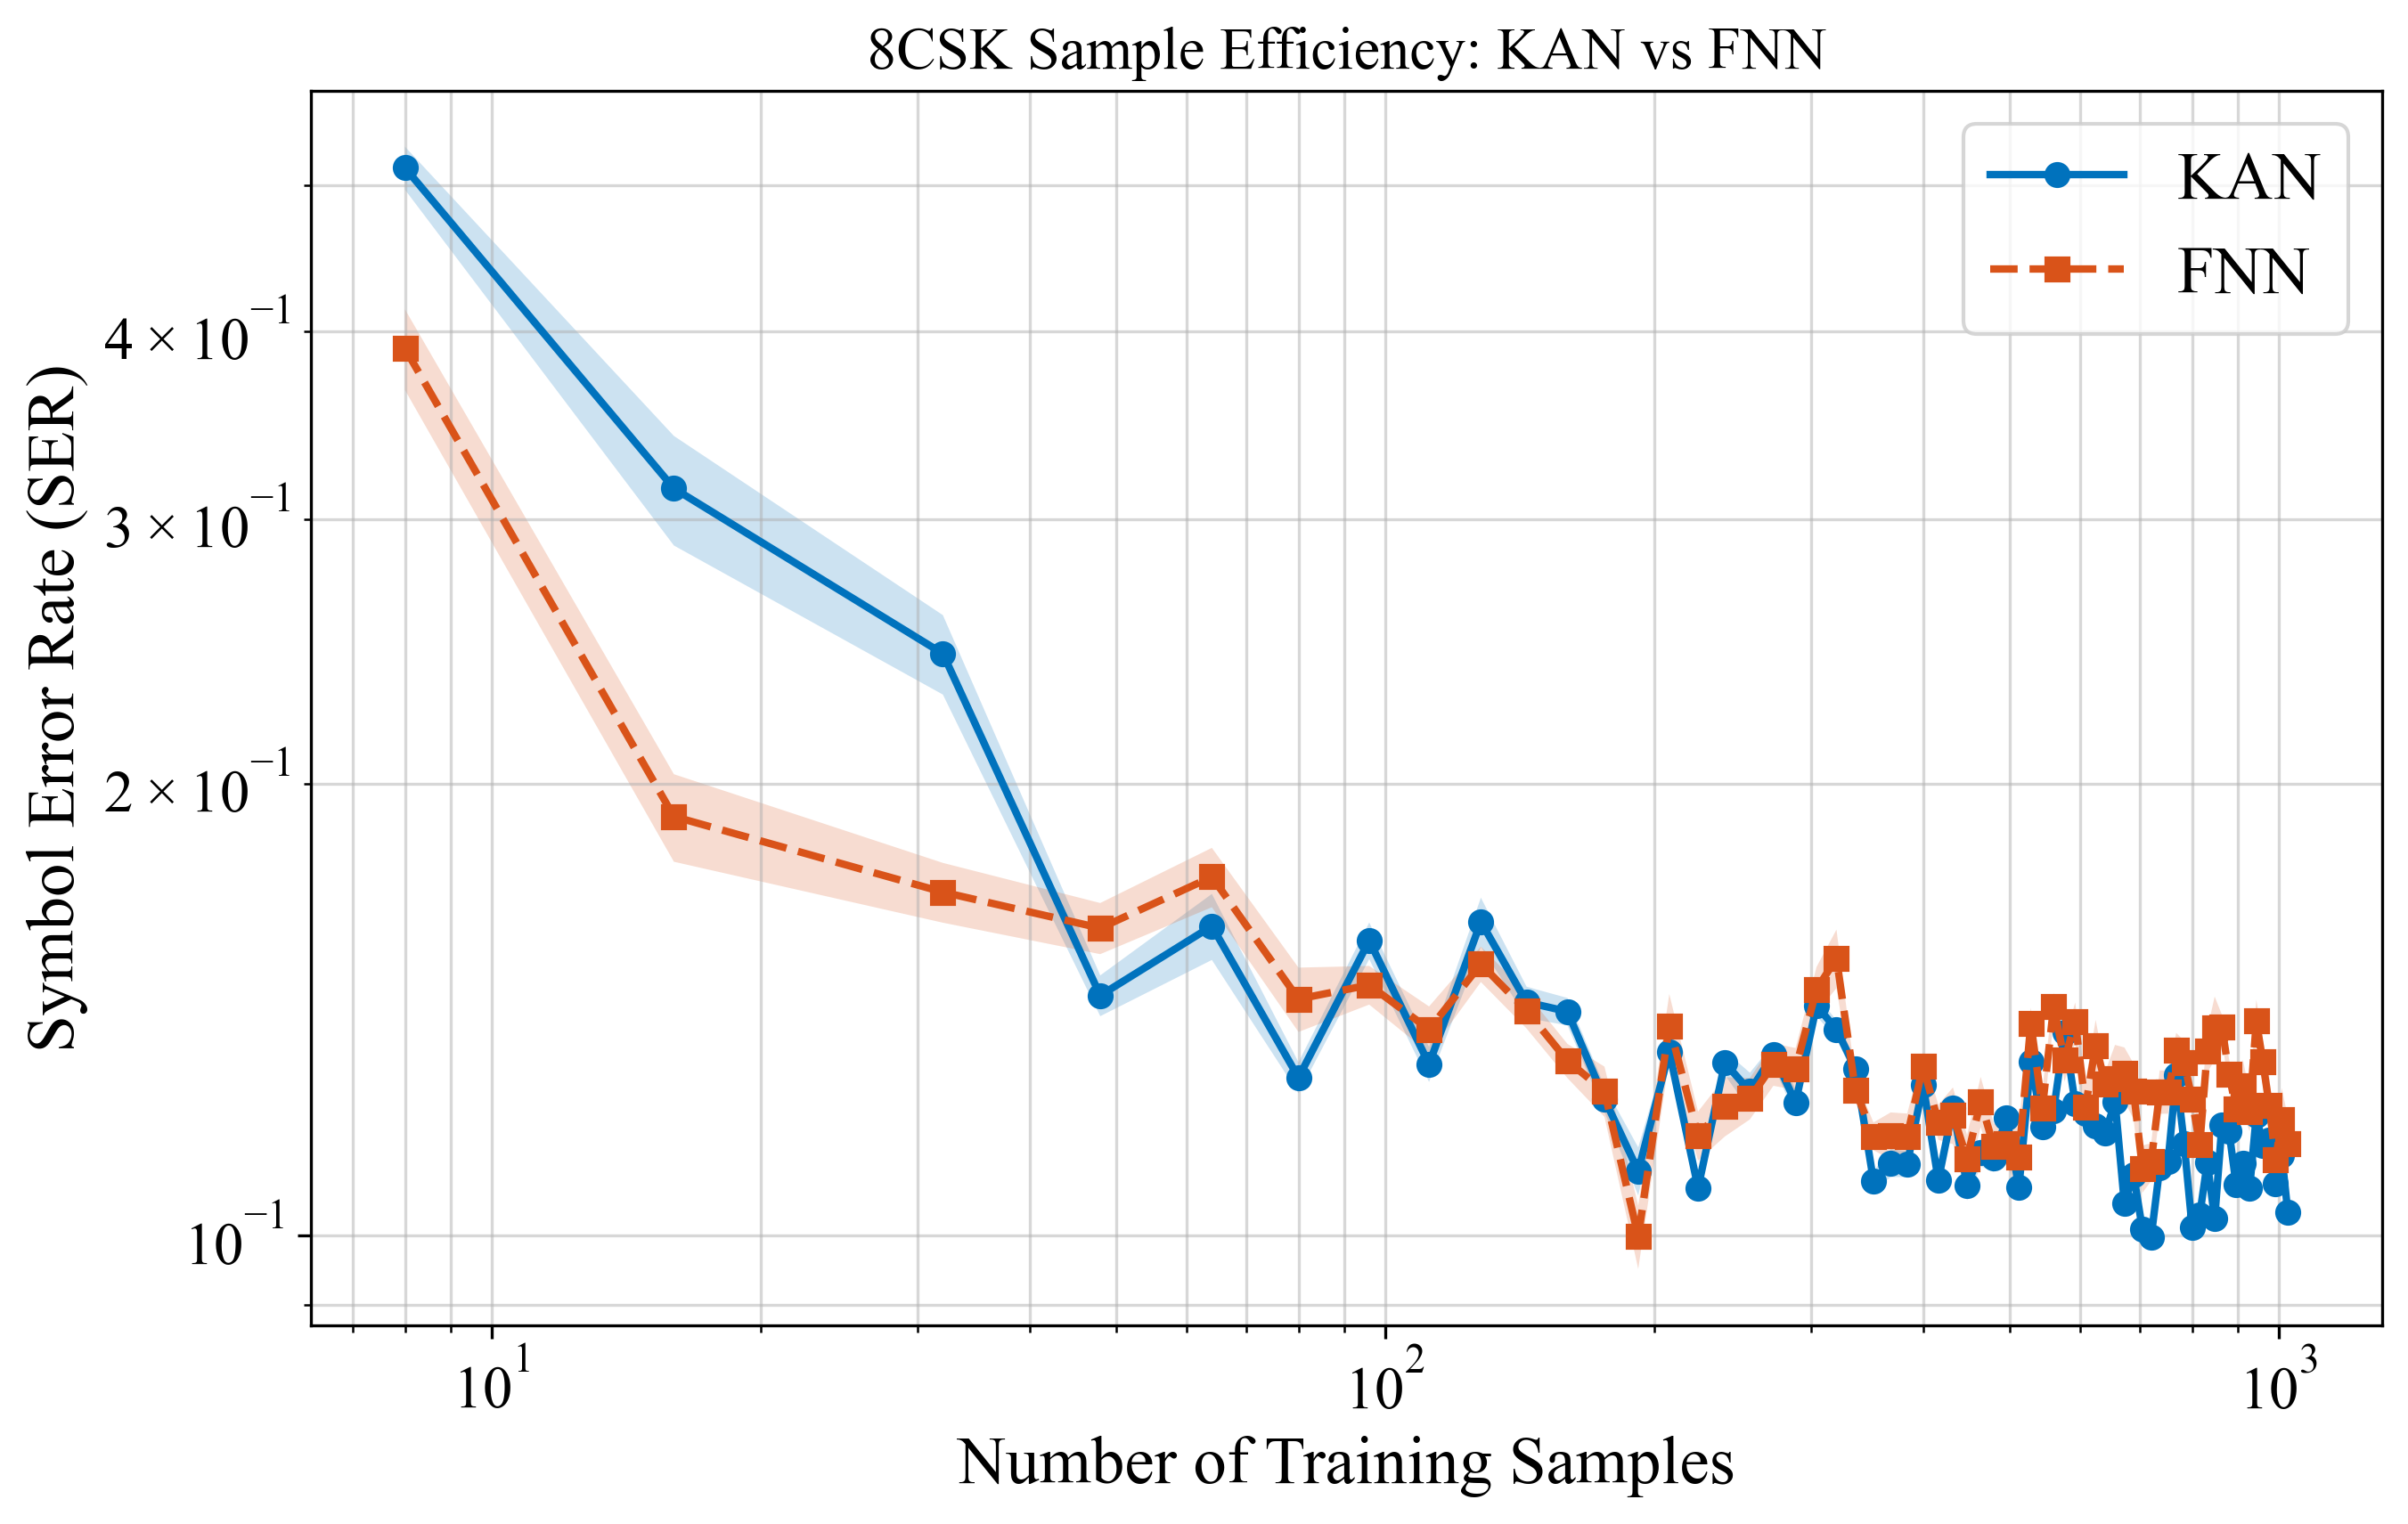

In [8]:
# --- Experiment 3a: KAN vs FNN Detailed Comparison (Sample Efficiency) ---
print("\n--- Experiment 3a: KAN vs FNN Detailed Comparison (Sample Efficiency) ---")
print("Training on [8, 16, 32...1024] samples, testing on 1024 samples")

# Define sample sizes: 8, then 16, 32, 48 ... 1024
TRAIN_SAMPLE_SIZES = [8] + list(range(16, 1025, 16))
TEST_SAMPLE_SIZE = 1024

# Increased repeats for statistical significance
N_REPEATS_SAMPLE_EFF = 10
SAMPLE_EFF_EPOCHS = 200

results_sample_eff = {
    'Dataset': [], 'Noise_Level': [], 'Model': [], 'Train_Samples': [],
    'Mean_SER': [], 'Std_SER': [], 'Mean_Accuracy': [], 'Std_Accuracy': []
}

for filename in ['data_4csk.csv', 'data_8csk.csv']:
    print(f"============================================================")
    print(f"Dataset: {filename}")
    print(f"============================================================")

    base_file = filename
    if 'best_features_global' in globals() and base_file in best_features_global:
         best_feat_config = best_features_global[base_file]
         best_kan_params = best_params_global[base_file]
         feature_cols = best_feat_config['cols']
         normalize_data = best_feat_config['norm']
    else:
        print(f"Warning: Best config for {base_file} not found. Using defaults.")
        feature_cols = ['R', 'G', 'B']
        normalize_data = True
        best_kan_params = {'hidden_layers': [10], 'grid': 3, 'k': 3, 'lr': 0.01, 'weight_decay': 1e-4}

    num_classes = 4 if '4csk' in filename else 8
    kan_layers = [len(feature_cols)] + best_kan_params['hidden_layers'] + [num_classes]
    fnn_hidden_layers = [10] if '4csk' in filename else [100]

    for train_size in TRAIN_SAMPLE_SIZES:
        # print(f"\--- Training with {train_size} samples ---") # Reduce spam
        if train_size % 128 == 0 or train_size == 8:
             print(f"Processing train size: {train_size}")
        
        kan_sers = []
        fnn_sers = []
        
        # Monte Carlo CV / Repeated Holdout
        for i in range(N_REPEATS_SAMPLE_EFF):
            # Load fresh split for each repetition
            X_train, X_test, y_train, y_test, _ = load_data(
                filename, feature_cols, train_size=train_size, test_size=TEST_SAMPLE_SIZE, normalize=normalize_data
            )
            
            if X_train is None: break
            
            # Train KAN
            kan_model = ReLUKAN(kan_layers, grid=best_kan_params['grid'], k=best_kan_params['k']).to(device)
            best_ser_kan, _, _ = train_model(kan_model, X_train, y_train, X_test, y_test, 
                                          epochs=SAMPLE_EFF_EPOCHS, lr=best_kan_params['lr'], weight_decay=best_kan_params['weight_decay'], verbose=False)
            kan_sers.append(best_ser_kan)
            
            # Train FNN
            fnn_model = FNN(len(feature_cols), fnn_hidden_layers, num_classes).to(device)
            best_ser_fnn, _, _ = train_model(fnn_model, X_train, y_train, X_test, y_test, 
                                          epochs=SAMPLE_EFF_EPOCHS, lr=0.001, weight_decay=1e-4, verbose=False)
            fnn_sers.append(best_ser_fnn)
        
        # Store results
        results_sample_eff['Dataset'].append(filename)
        results_sample_eff['Noise_Level'].append('No Noise')
        results_sample_eff['Model'].append('KAN')
        results_sample_eff['Train_Samples'].append(train_size)
        results_sample_eff['Mean_SER'].append(np.mean(kan_sers))
        results_sample_eff['Std_SER'].append(np.std(kan_sers))
        results_sample_eff['Mean_Accuracy'].append(1.0 - np.mean(kan_sers))
        results_sample_eff['Std_Accuracy'].append(np.std(kan_sers))
        
        results_sample_eff['Dataset'].append(filename)
        results_sample_eff['Noise_Level'].append('No Noise')
        results_sample_eff['Model'].append('FNN')
        results_sample_eff['Train_Samples'].append(train_size)
        results_sample_eff['Mean_SER'].append(np.mean(fnn_sers))
        results_sample_eff['Std_SER'].append(np.std(fnn_sers))
        results_sample_eff['Mean_Accuracy'].append(1.0 - np.mean(fnn_sers))
        results_sample_eff['Std_Accuracy'].append(np.std(fnn_sers))

# Save Results
df_sample = pd.DataFrame(results_sample_eff)
df_sample.to_csv(os.path.join(OUTPUT_DIR, 'results_sample_efficiency_refined.csv'), index=False)
print("Sample Efficiency Experiment Complete.")

# --- Sample Efficiency Plotting ---
print("Generating Sample Efficiency Plots...")
try:
    if os.path.exists(os.path.join(OUTPUT_DIR, 'results_sample_efficiency_refined.csv')):
        df_sample = pd.read_csv(os.path.join(OUTPUT_DIR, 'results_sample_efficiency_refined.csv'))
    else:
        # Fallback to current in-memory dictionary if dataframe not yet saved/reloaded
        df_sample = pd.DataFrame(results_sample_eff)

    # Plotting Loop
    for mod in ['4CSK', '8CSK']:
        # Filter by dataset name containing the mod string (e.g. 'data_4csk.csv')
        subset = df_sample[df_sample['Dataset'].astype(str).str.contains(mod, case=False)]
        if subset.empty: 
            continue
        
        plt.figure(figsize=(10, 6))
        
        models = subset['Model'].unique()
        markers = {'KAN': 'o', 'FNN': 's'}
        linestyles = {'KAN': '-', 'FNN': '--'}
        
        for model_name in models:
            model_data = subset[subset['Model'] == model_name].sort_values('Train_Samples')
            
            # Plot Mean SER
            plt.plot(model_data['Train_Samples'], model_data['Mean_SER'], 
                     label=model_name, 
                     marker=markers.get(model_name, 'x'), 
                     linestyle=linestyles.get(model_name, '-'))
            
            # Shaded Error Bar (Standard Deviation)
            plt.fill_between(model_data['Train_Samples'], 
                             np.clip(model_data['Mean_SER'] - model_data['Std_SER'], 0, None),
                             model_data['Mean_SER'] + model_data['Std_SER'],
                             alpha=0.2)
        
        plt.yscale('log')
        plt.xscale('log')
        plt.title(f'{mod} Sample Efficiency: KAN vs FNN')
        plt.xlabel('Number of Training Samples')
        plt.ylabel('Symbol Error Rate (SER)')
        plt.legend()
        plt.grid(True, which='both', ls='-', alpha=0.5)
        
        outfile = os.path.join(OUTPUT_DIR, f'plot_sample_efficiency_{mod}.pdf')
        plt.savefig(outfile, format='pdf', dpi=300)
        plt.savefig(outfile.replace('.pdf', '.png'), dpi=300)
        print(f'Saved plot to {outfile}')
        plt.show()
except Exception as e:
    print(f'Error in plotting block: {e}')

## 6. Experiment 4: Convergence Analysis

--- Experiment 4: Convergence Analysis ---


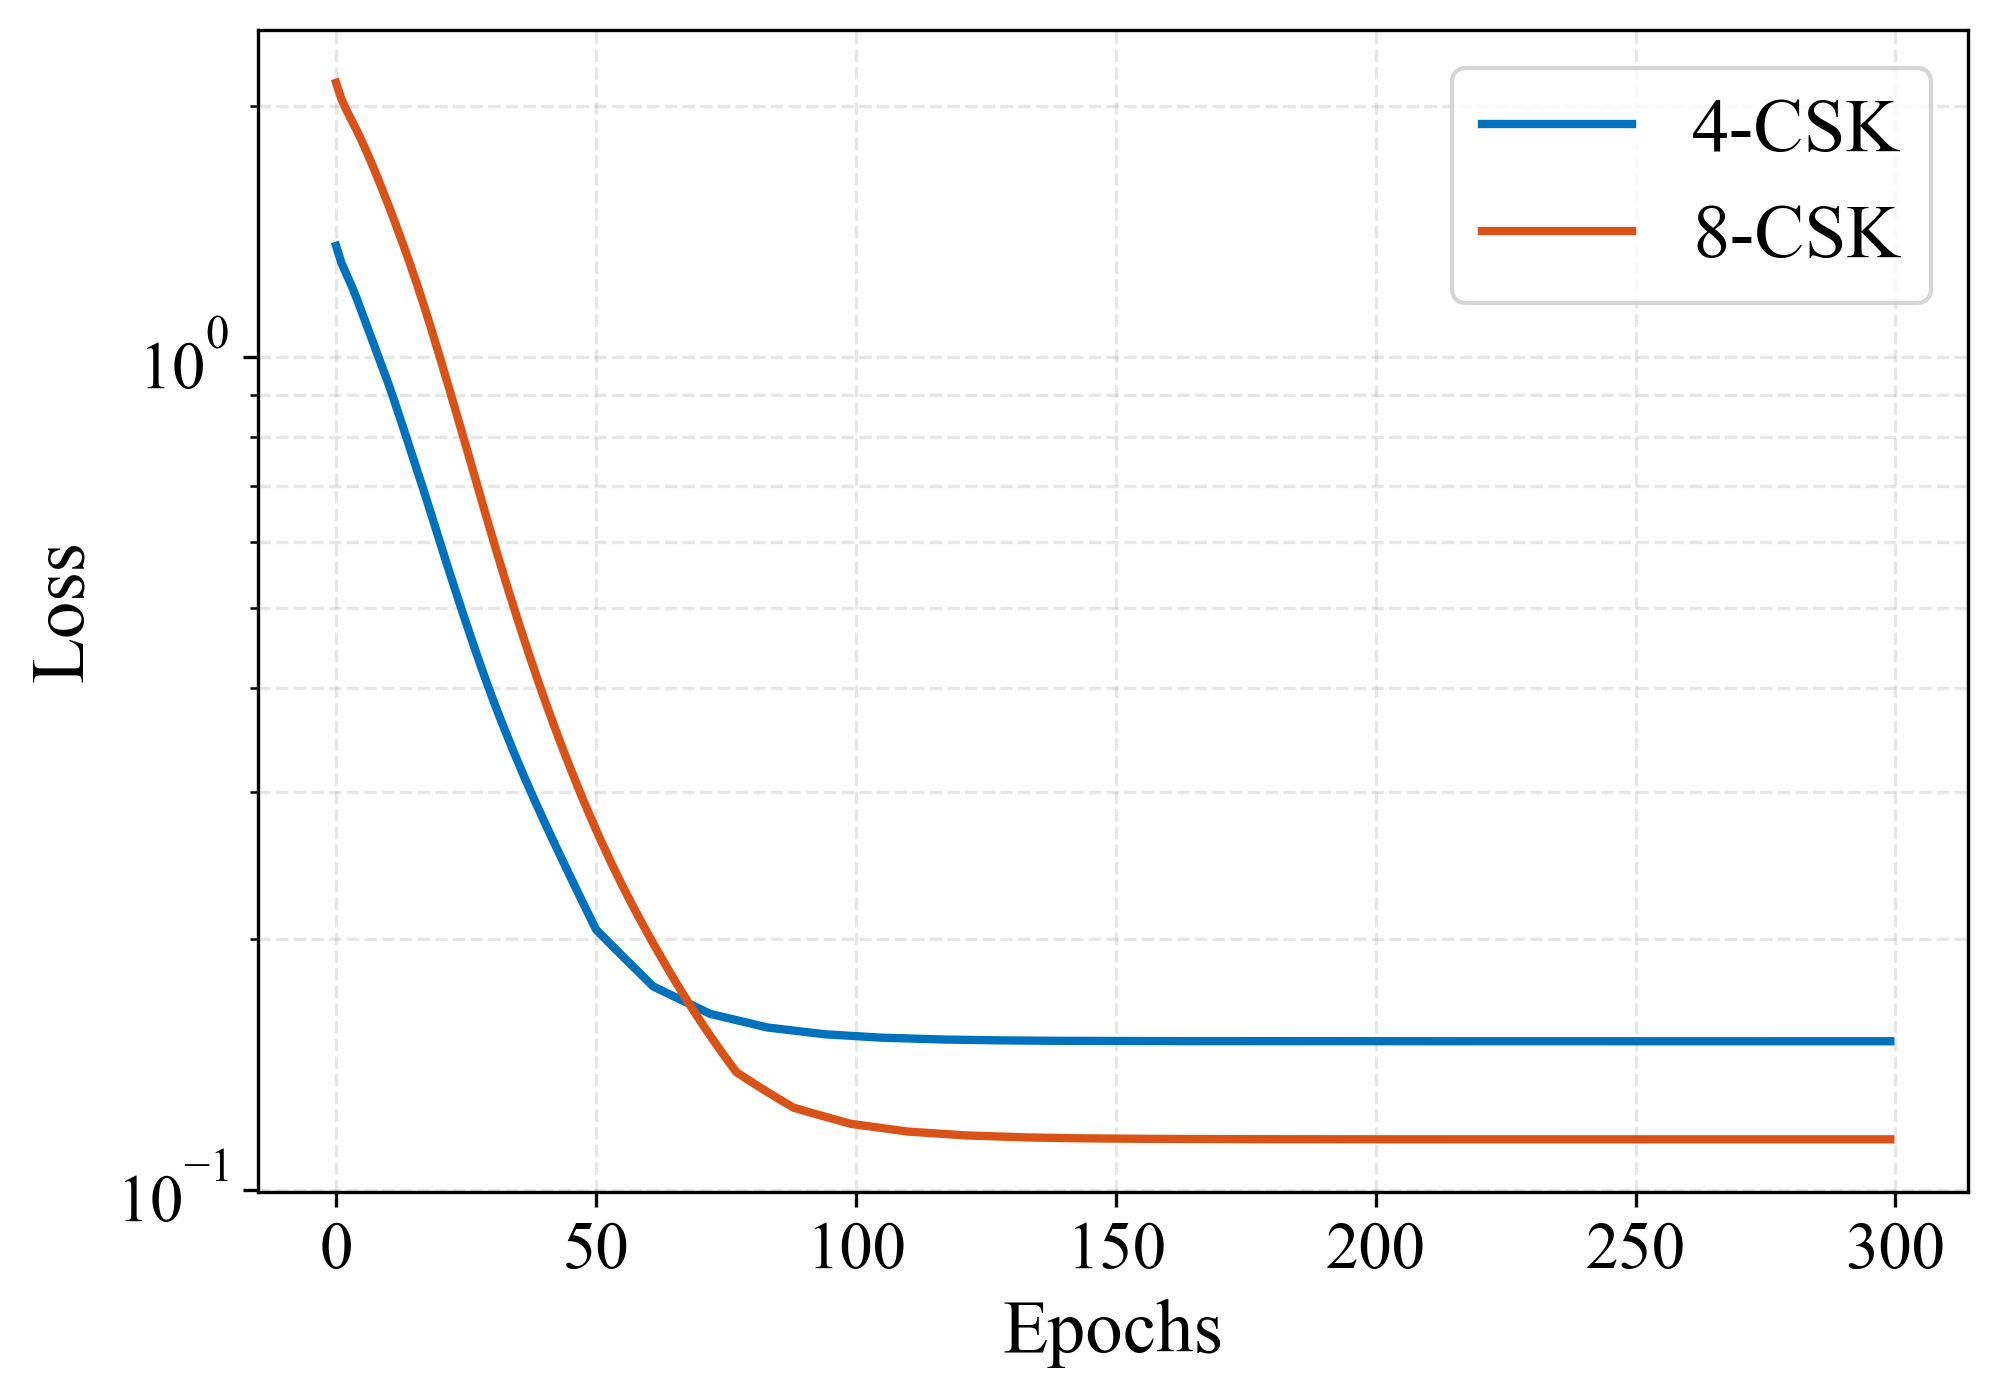

In [9]:
print("--- Experiment 4: Convergence Analysis ---")
plt.figure(figsize=(7, 5))
for filename in ['data_4csk.csv', 'data_8csk.csv']:
    if 'best_features_global' in locals() and filename in best_features_global:
        feat_cols = best_features_global[filename]['cols']
        do_norm = best_features_global[filename]['norm']
    else:
        feat_cols = ['Vr', 'Vg', 'Vb']
        do_norm = True
            
    if 'best_params_global' in locals() and filename in best_params_global:
        params = best_params_global[filename]
    else:
        params = {'grid': 5, 'k': 3, 'lr': 0.01, 'weight_decay': 1e-4}
    X_train, X_test, y_train, y_test, num_classes = load_data(filename, feat_cols, normalize=do_norm)
    
    hidden = params.get('hidden_layers', [8])
    layers = [len(feat_cols)] + hidden + [num_classes]
    model = ReLUKAN(layers, grid=params['grid'], k=params['k']).to(device)
    _, history, _ = train_model(model, X_train, y_train, X_test, y_test, epochs=300, lr=params['lr'], weight_decay=params['weight_decay'], verbose=False)
    
    clean_label = '4-CSK' if '4csk' in filename else '8-CSK'
    plt.plot(history['train_loss'], label=clean_label)
    # plt.plot(history['test_ser'], label=f'{filename} Test SER', linestyle='--')

# plt.title('Training Convergence')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.yscale('log')
plt.grid(True, which="both", ls="--")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'plot_convergence.png'), dpi=300)
plt.savefig(os.path.join(OUTPUT_DIR, 'plot_convergence.pdf'), format='pdf', dpi=300)

## 7. Transfer Learning & Detailed Evaluation

<>:2: SyntaxWarning: invalid escape sequence '\-'
<>:56: SyntaxWarning: invalid escape sequence '\P'
<>:2: SyntaxWarning: invalid escape sequence '\-'
<>:56: SyntaxWarning: invalid escape sequence '\P'
C:\Users\Rafael\AppData\Local\Temp\ipykernel_9964\3545858429.py:2: SyntaxWarning: invalid escape sequence '\-'
  print("\--- Experiment 4: Noise Level Comparison (Theoretical MLE - Raw x,y) ---")
C:\Users\Rafael\AppData\Local\Temp\ipykernel_9964\3545858429.py:56: SyntaxWarning: invalid escape sequence '\P'
  print(f"\Processing {mod} Noise Sweep (Theoretical MLE - x,y)...")


\--- Experiment 4: Noise Level Comparison (Theoretical MLE - Raw x,y) ---
\Processing 4csk Noise Sweep (Theoretical MLE - x,y)...
  MLE configured with centroids from data_4csk_m1000dB.csv
  Noise: -60 dB (data_4csk_m60dB.csv)
    MLE: 0.0000 | KAN: 0.0000 | FNN: 0.0916
  Noise: -58 dB (data_4csk_m58dB.csv)
    MLE: 0.0000 | KAN: 0.0000 | FNN: 0.0520
  Noise: -56 dB (data_4csk_m56dB.csv)
    MLE: 0.0000 | KAN: 0.0000 | FNN: 0.0301
  Noise: -54 dB (data_4csk_m54dB.csv)
    MLE: 0.0000 | KAN: 0.0000 | FNN: 0.0838
  Noise: -52 dB (data_4csk_m52dB.csv)
    MLE: 0.0010 | KAN: 0.0000 | FNN: 0.0725
  Noise: -50 dB (data_4csk_m50dB.csv)
    MLE: 0.0029 | KAN: 0.0000 | FNN: 0.0744
  Noise: -48 dB (data_4csk_m48dB.csv)
    MLE: 0.0166 | KAN: 0.0012 | FNN: 0.1336
  Noise: -46 dB (data_4csk_m46dB.csv)
    MLE: 0.0430 | KAN: 0.0123 | FNN: 0.1914
  Noise: -44 dB (data_4csk_m44dB.csv)
    MLE: 0.1094 | KAN: 0.0348 | FNN: 0.1910
  Noise: -42 dB (data_4csk_m42dB.csv)
    MLE: 0.1602 | KAN: 0.0867 | FNN

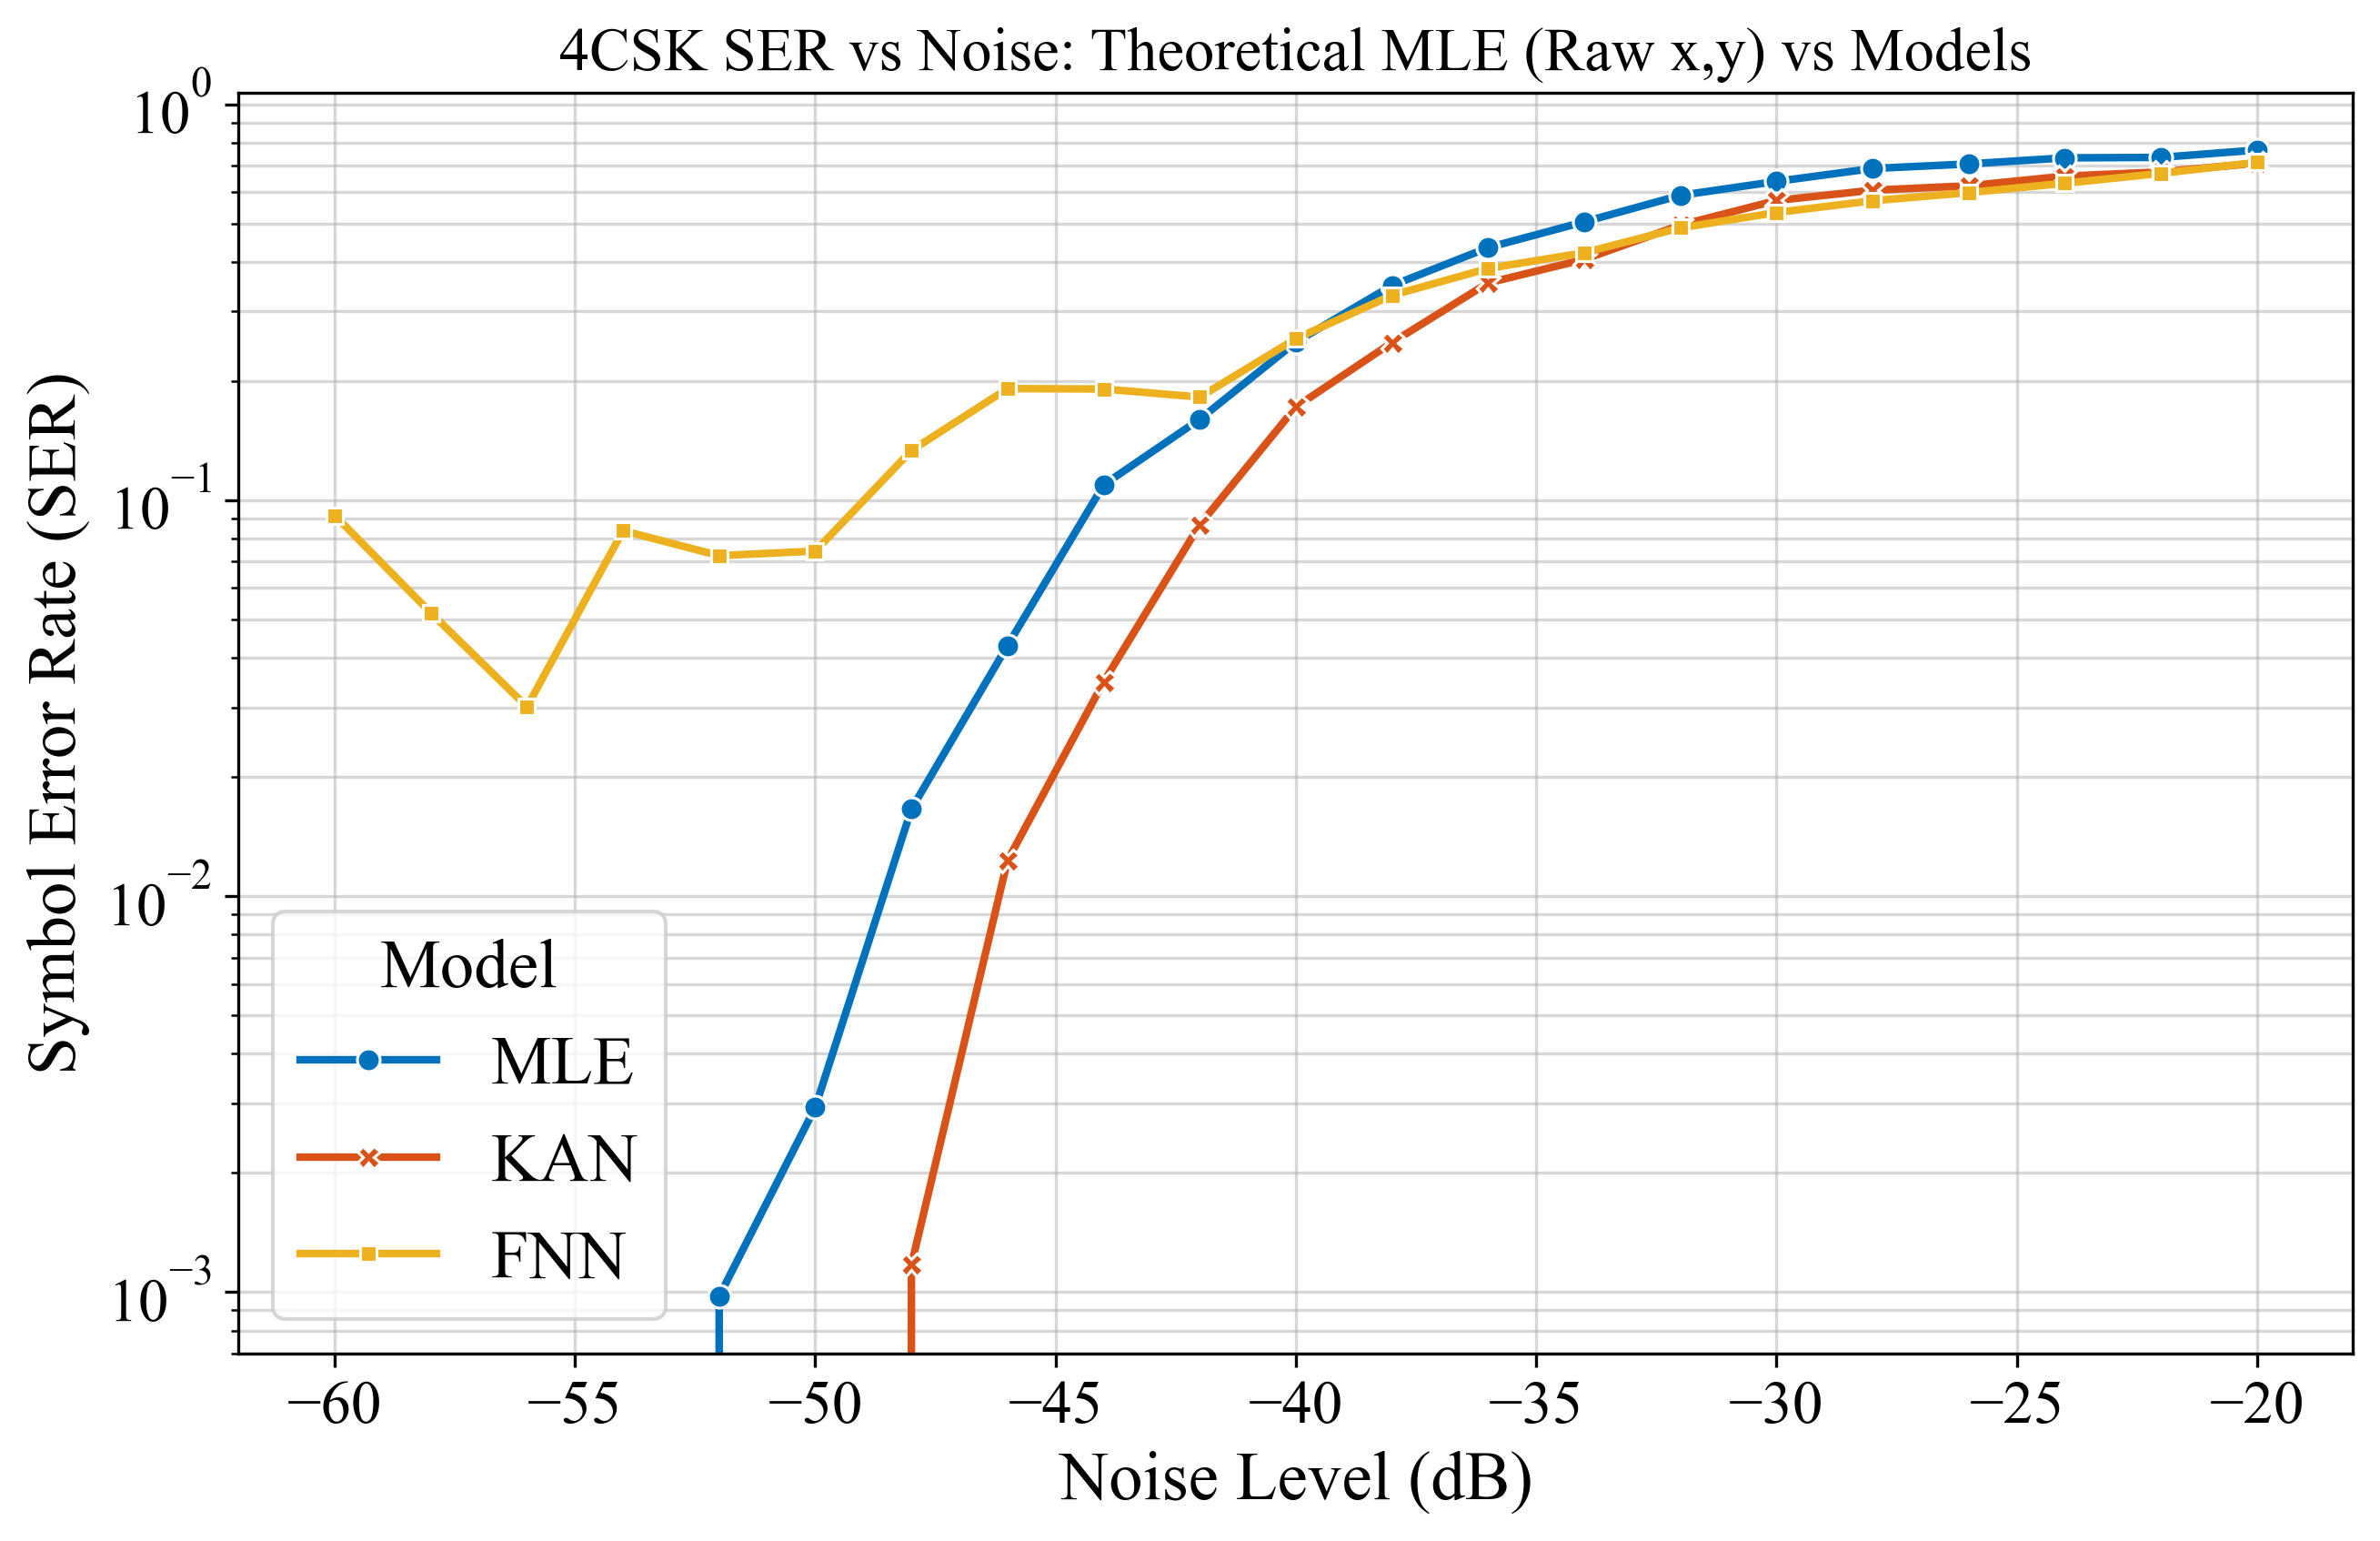

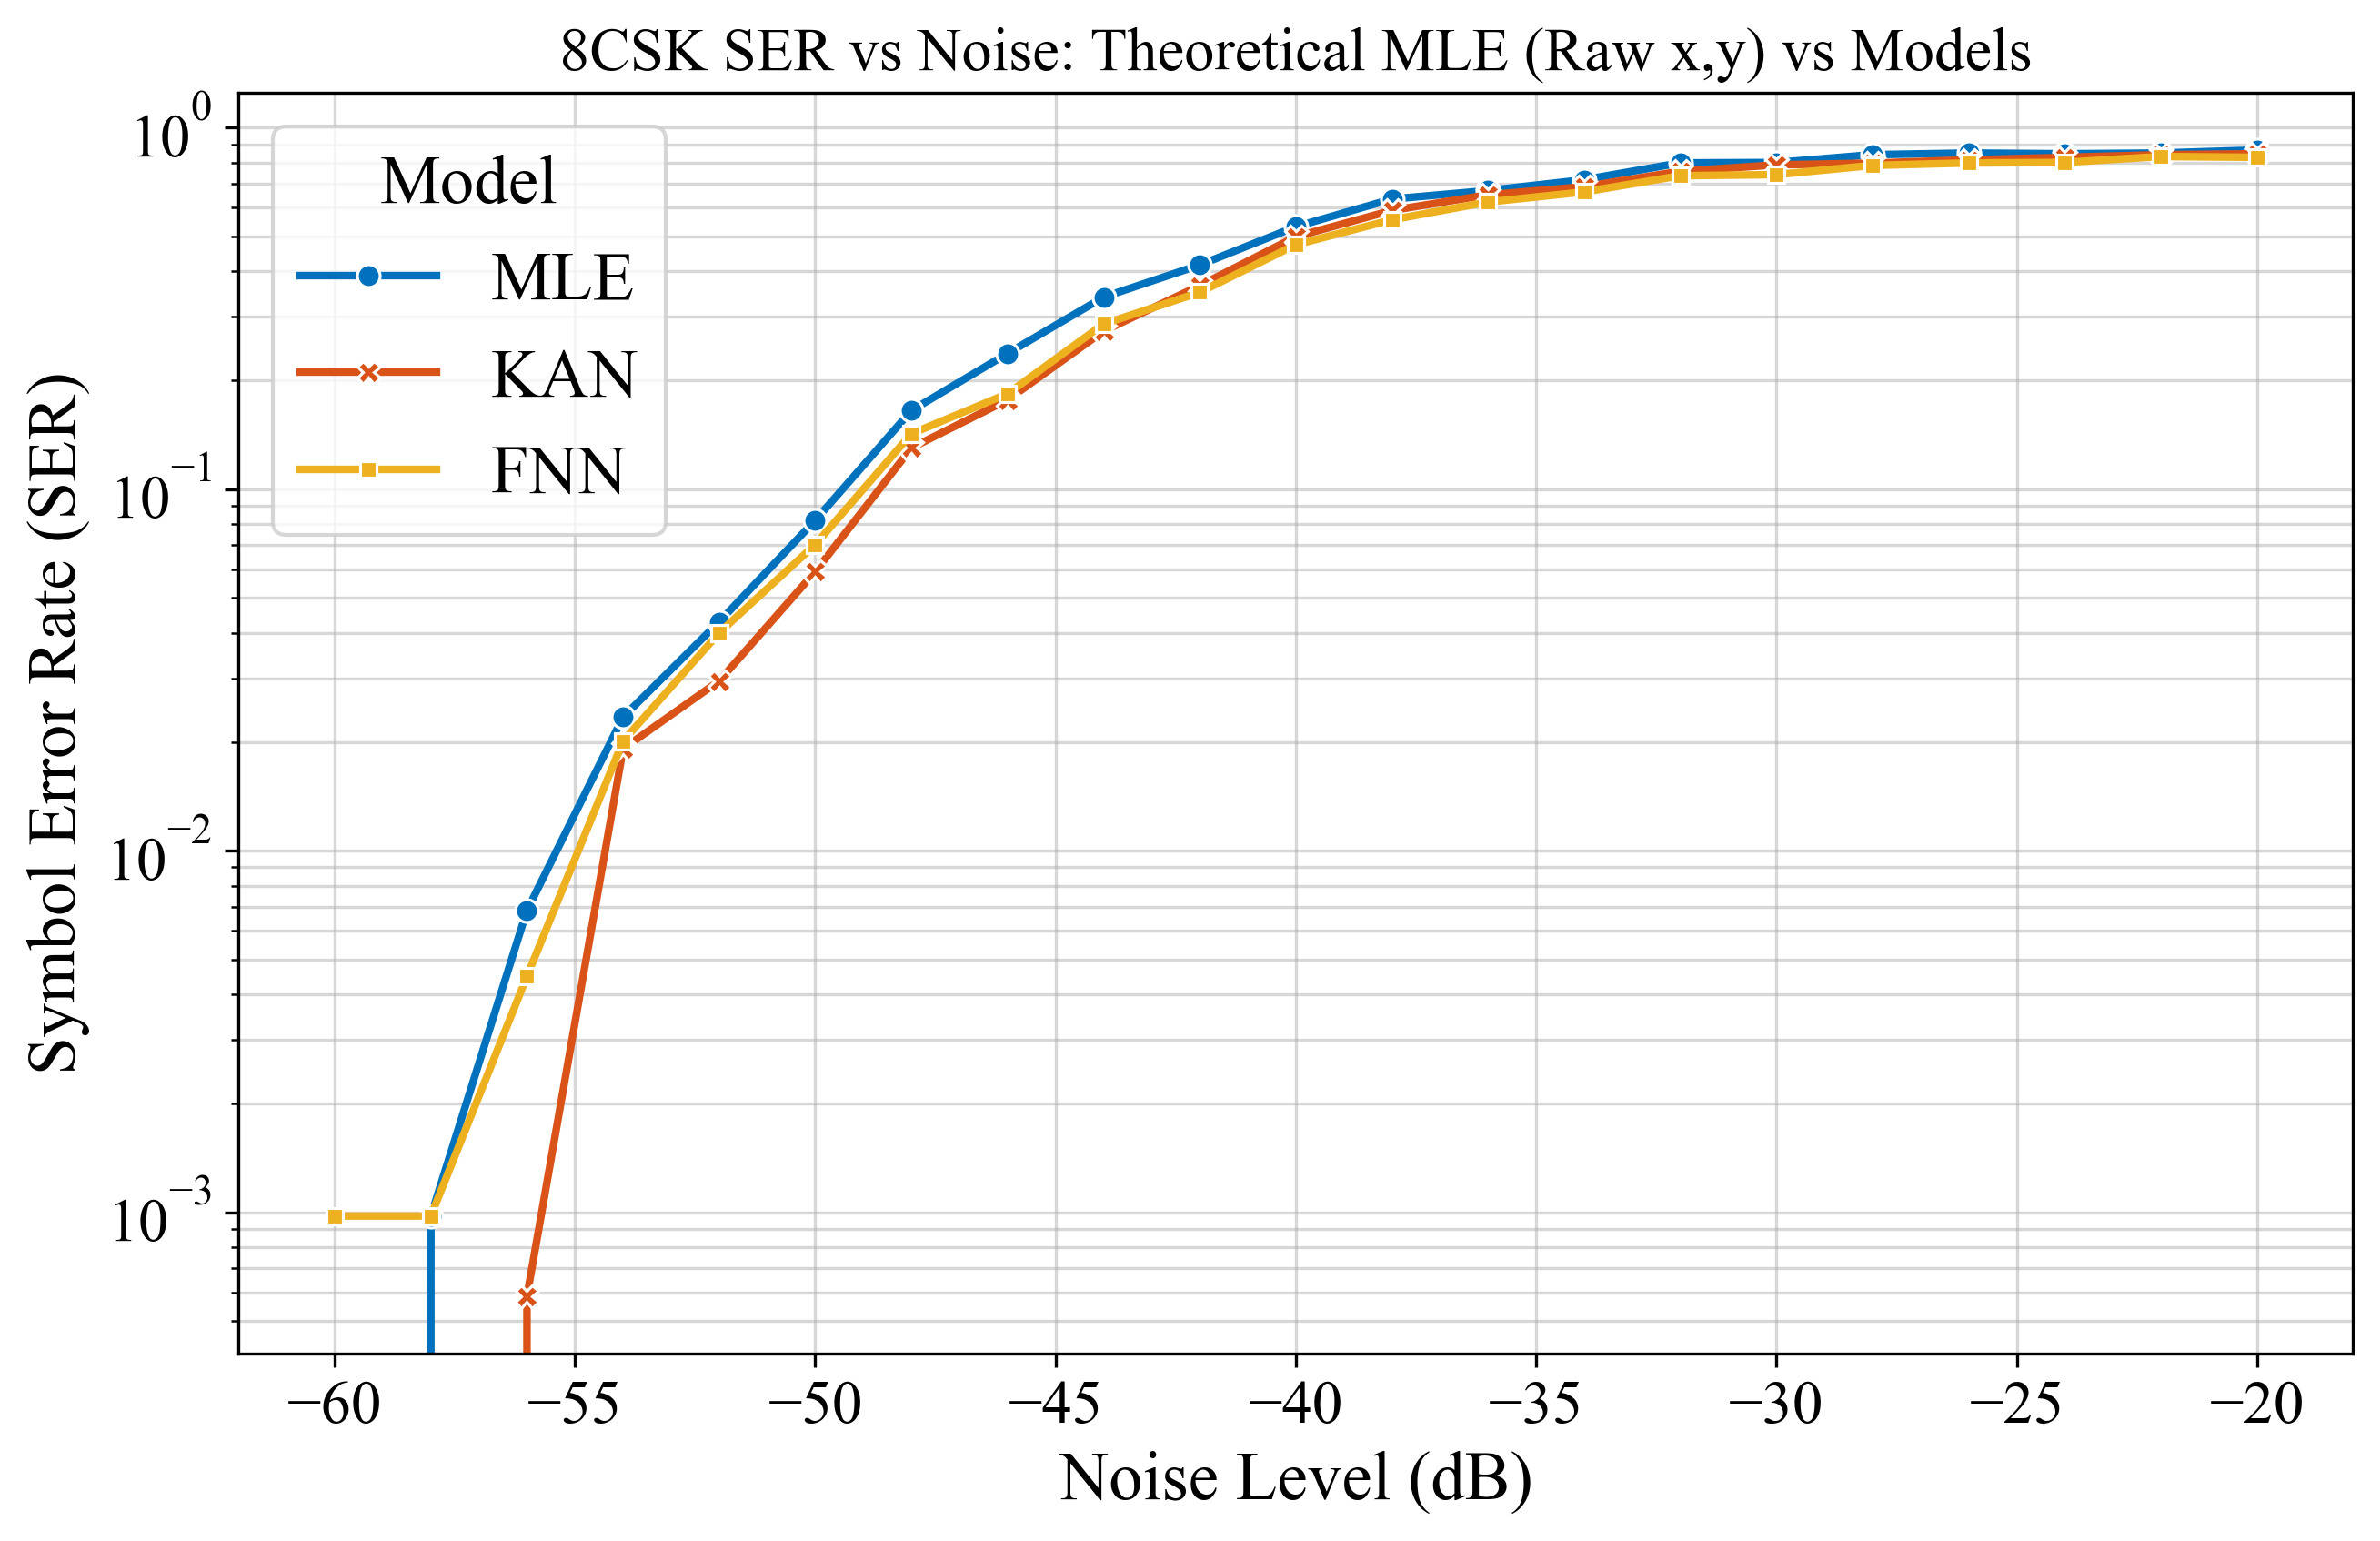

In [10]:
# --- Experiment 4: Noise Level Comparison (Theoretical MLE - Raw x,y) ---
print("\--- Experiment 4: Noise Level Comparison (Theoretical MLE - Raw x,y) ---")

import glob
import os
import numpy as np
import torch
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Pure Distance-Based Classifier (No Training)
class TheoreticalMLE:
    def __init__(self, centroids, classes):
        # centroids: numpy array of shape (n_classes, n_features)
        # classes: list of class labels corresponding to centroids
        self.centroids = centroids
        self.classes = classes

    def predict(self, X):
        # X: numpy array (n_samples, n_features)
        if isinstance(X, torch.Tensor): X = X.cpu().numpy()
        if X.ndim == 3 and X.shape[-1] == 1: X = X.squeeze(-1)
        
        preds = []
        for x in X:
            # Euclidean distance to each centroid
            dists = [np.linalg.norm(x - c) for c in self.centroids]
            preds.append(self.classes[np.argmin(dists)])
        return np.array(preds)

TRAIN_SIZE_NOISE = 1024
TEST_SIZE_NOISE = 1024
N_REPEATS_NOISE = 5
NOISE_EPOCHS = 200
MLE_FEATURES = ['x', 'y']

results_noise = {'Modulation': [], 'Noise_dB': [], 'Model': [], 'Mean_SER': [], 'Std_SER': []}

files_by_mod = {'4csk': [], '8csk': []}
all_files = glob.glob("data_*csk_m*dB.csv")
for f in all_files:
    try:
        parts = f.split('_')
        if len(parts) >= 3 and 'm1000' not in f:
            mod_type = parts[1]
            last_part = parts[2].replace('.csv', '')
            if 'dB' in last_part and 'm' in last_part:
                val_str = last_part.replace('dB', '').replace('m', '')
                noise_val = -int(val_str)
                if mod_type in files_by_mod:
                    files_by_mod[mod_type].append({'file': f, 'dB': noise_val})
    except: pass

for mod in ['4csk', '8csk']:
    files_by_mod[mod].sort(key=lambda x: x['dB'])
    print(f"\Processing {mod} Noise Sweep (Theoretical MLE - x,y)...")
    
    # 1. Setup Theoretical MLE (Load once, no training)
    ref_file = f"data_{mod}_m1000dB.csv"
    try:
        df_ref = pd.read_csv(ref_file)
        # Get unique symbols and their ideal centroids
        # Assuming m1000dB file has perfect or mean centroids. 
        # We group by Symbol to get the exact center for each class.
        ref_grouped = df_ref.groupby('Symbol')[MLE_FEATURES].mean()
        
        # Extract aligned arrays
        theo_classes = ref_grouped.index.values
        theo_centroids = ref_grouped.values
        
        # Instantiate ONE theoretical model for this modulation
        mle_model = TheoreticalMLE(theo_centroids, theo_classes)
        print(f"  MLE configured with centroids from {ref_file}")
    except FileNotFoundError:
        print(f"  Error: Reference file {ref_file} not found! Skipping.")
        continue

    # 2. Setup KAN/FNN Config
    base_file = f"data_{mod}.csv"
    if 'best_features_global' in globals() and base_file in best_features_global:
         best_feat_config = best_features_global[base_file]
         best_kan_params = best_params_global[base_file]
         kan_feature_cols = best_feat_config['cols']
         nn_normalize = best_feat_config['norm']
    else:
        kan_feature_cols = ['R', 'G', 'B']
        nn_normalize = True
        best_kan_params = {'hidden_layers': [10], 'grid': 3, 'k': 3, 'lr': 0.01, 'weight_decay': 1e-4}

    num_classes = 4 if '4csk' in mod else 8
    fnn_hidden = [10] if '4csk' in mod else [100]

    # 3. Noise Loop
    for item in files_by_mod[mod]:
        fpath = item['file']
        noise_db = item['dB']
        print(f"  Noise: {noise_db} dB ({fpath})")

        # --- MLE EVALUATION (Available Test Data, RAW) ---
        # We load normalized=False to get raw x,y comparable to m1000dB
        _, X_test_raw, _, y_test_t, _ = load_data(
            fpath, MLE_FEATURES, train_size=TRAIN_SIZE_NOISE, test_size=TEST_SIZE_NOISE, normalize=False, return_numpy=True
        )
        
        if X_test_raw is not None:
            # Directly predict using theoretical centroids
            mle_preds = mle_model.predict(X_test_raw)
            mle_ser = 1.0 - (mle_preds == y_test_t).mean()
            
            results_noise['Modulation'].append(mod.upper())
            results_noise['Noise_dB'].append(noise_db)
            results_noise['Model'].append('MLE')
            results_noise['Mean_SER'].append(mle_ser)
            results_noise['Std_SER'].append(0.0)
        else:
            mle_ser = 1.0

        # --- KAN/FNN TRAINING (Scaled) ---
        # Neural nets train better with normalization, so we keep their best config
        X_train, X_test, y_train, y_test, _ = load_data(
            fpath, kan_feature_cols, train_size=TRAIN_SIZE_NOISE, test_size=TEST_SIZE_NOISE, normalize=nn_normalize
        )
        
        kan_sers, fnn_sers = [], []
        
        # Train KAN
        kan_layers = [len(kan_feature_cols)] + best_kan_params['hidden_layers'] + [num_classes]
        for _ in range(N_REPEATS_NOISE):
            model = ReLUKAN(kan_layers, grid=best_kan_params['grid'], k=best_kan_params['k']).to(device)
            best_ser, _, _ = train_model(model, X_train, y_train, X_test, y_test, 
                                      epochs=NOISE_EPOCHS, lr=best_kan_params['lr'], weight_decay=best_kan_params['weight_decay'])
            kan_sers.append(best_ser)
        
        results_noise['Modulation'].append(mod.upper())
        results_noise['Noise_dB'].append(noise_db)
        results_noise['Model'].append('KAN')
        results_noise['Mean_SER'].append(np.mean(kan_sers))
        results_noise['Std_SER'].append(np.std(kan_sers))

        # Train FNN
        for _ in range(N_REPEATS_NOISE):
            model = FNN(len(kan_feature_cols), fnn_hidden, num_classes).to(device)
            best_ser, _, _ = train_model(model, X_train, y_train, X_test, y_test, epochs=NOISE_EPOCHS, lr=0.001, weight_decay=1e-4)
            fnn_sers.append(best_ser)
        
        results_noise['Modulation'].append(mod.upper())
        results_noise['Noise_dB'].append(noise_db)
        results_noise['Model'].append('FNN')
        results_noise['Mean_SER'].append(np.mean(fnn_sers))
        results_noise['Std_SER'].append(np.std(fnn_sers))
        
        print(f"    MLE: {mle_ser:.4f} | KAN: {np.mean(kan_sers):.4f} | FNN: {np.mean(fnn_sers):.4f}")

# Save and Plot
df_noise = pd.DataFrame(results_noise)
df_noise.to_csv(os.path.join(OUTPUT_DIR, 'results_noise_comparison.csv'), index=False)

for mod in ['4CSK', '8CSK']:
    subset = df_noise[df_noise['Modulation'] == mod]
    if subset.empty: continue
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=subset, x='Noise_dB', y='Mean_SER', hue='Model', style='Model', markers=True, dashes=False)
    plt.yscale('log')
    plt.title(f'{mod} SER vs Noise: Theoretical MLE (Raw x,y) vs Models')
    plt.xlabel('Noise Level (dB)')
    plt.ylabel('Symbol Error Rate (SER)')
    plt.grid(True, which="both", ls="-", alpha=0.5)
    out_path = os.path.join(OUTPUT_DIR, f'plot_noise_comparison_{mod}.pdf')
    plt.savefig(out_path, format='pdf', dpi=300)
    plt.savefig(out_path.replace('.pdf', '.png'), dpi=300)
    plt.show()